In [1]:
import os
import cv2
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from tensorflow.keras import layers, models

2025-09-07 13:03:04.452909: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757250184.607606      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757250184.654882      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
DATA_DIR = "/kaggle/input/shopdata/Shop DataSet"
CACHE_DIR = "/kaggle/working/video_cache_frames32"
os.makedirs(CACHE_DIR, exist_ok=True)

In [3]:
import shutil
shutil.rmtree(CACHE_DIR)
os.makedirs(CACHE_DIR, exist_ok=True)# to clear caches 

In [4]:
NUM_FRAMES = 12
IMG_SIZE = 128 #128 if the model is build from scratch
BATCH_SIZE = 24
CLASSES = ["non shop lifters", "shop lifters"]

In [5]:
for cls in CLASSES:
    class_folder = os.path.join(DATA_DIR, cls)
    files = [f for f in os.listdir(class_folder) if f.lower().endswith((".mp4", ".avi", ".mov", ".mkv"))]
    print(f"Class '{cls}' has {len(files)} files:")
    for filename in files:
        print(f" - {filename}")
    print()

Class 'non shop lifters' has 531 files:
 - shop_lifter_n_216.mp4
 - shop_lifter_n_98.mp4
 - shop_lifter_n_137.mp4
 - shop_lifter_n_86_1.mp4
 - shop_lifter_n_19_1.mp4
 - shop_lifter_n_202.mp4
 - shop_lifter_n_159.mp4
 - shop_lifter_n_217.mp4
 - shop_lifter_n_185_1.mp4
 - shop_lifter_n_40_1.mp4
 - shop_lifter_n_107.mp4
 - videppppsss_37.mp4
 - shop_lifter_n_218_1.mp4
 - shop_lifter_n_140_1.mp4
 - shop_lifter_n_32_1.mp4
 - shop_lifter_n_190.mp4
 - videppppsss_39.mp4
 - shop_lifter_n_212.mp4
 - shop_lifter_n_173.mp4
 - shop_lifter_n_70_1.mp4
 - videppppsss_77.mp4
 - shop_lifter_n_44.mp4
 - videppppsss_0.mp4
 - shop_lifter_n_154.mp4
 - shop_lifter_n_98_1.mp4
 - videppppsss_34.mp4
 - videossssstttsss_48.mp4
 - shop_lifter_n_130.mp4
 - shop_lifter_n_96_1.mp4
 - shop_lifter_n_123.mp4
 - shop_lifter_n_93.mp4
 - shop_lifter_n_16_1.mp4
 - videppppsss_47.mp4
 - shop_lifter_n_24_1.mp4
 - shop_lifter_n_213_1.mp4
 - shop_lifter_n_214_1.mp4
 - shop_lifter_n_36.mp4
 - shop_lifter_n_170.mp4
 - videpppps

In [6]:
def load_video(path, max_frames=NUM_FRAMES, resize=(IMG_SIZE, IMG_SIZE), diff_threshold=1e-3):
    cap = cv2.VideoCapture(path)
    frames = []
    last_frame = None
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    skip = max(1, length // (max_frames * 2))  # sample more frames to filter duplicates

    for i in range(0, length, skip):
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_resized = cv2.resize(frame_rgb, resize)
        frame_norm = frame_resized.astype(np.float32) / 255.0

        if last_frame is not None:
            # Compute normalized difference between current frame and last kept frame
            diff = np.mean(np.abs(frame_norm - last_frame))
            if diff < diff_threshold:
                # Duplicate/similar – skip this frame
                continue

        frames.append(frame_norm)
        last_frame = frame_norm

        if len(frames) == max_frames:
            break

    cap.release()

    # If we still have fewer than max_frames, pad with zeros
    if len(frames) < max_frames:
        pad_len = max_frames - len(frames)
        frames = np.concatenate(
            [np.array(frames), np.zeros((pad_len, *resize, 3), dtype=np.float32)], axis=0
        )
    else:
        frames = np.array(frames, dtype=np.float32)

    return frames


In [7]:
def get_file_list(data_dir, classes):
    file_list = []
    for label, cls in enumerate(classes):
        folder = os.path.join(data_dir, cls)
        for file in os.listdir(folder):
            if file.lower().endswith((".mp4", ".avi", ".mov", ".mkv")):
                file_list.append((os.path.join(folder, file), label))
    return file_list

all_files = get_file_list(DATA_DIR, CLASSES)
# Remove duplicate file names across classes
seen = set()
unique_files = []
for path, label in all_files:
    fname = os.path.basename(path)
    if fname not in seen:
        unique_files.append((path, label))
        seen.add(fname)
    else:
        # Alternatively: you can keep track if needed
        pass

print("Original files:", len(all_files))
print("Unique by filename:", len(unique_files))

def split_dataset(file_list, train_ratio=0.7, val_ratio=0.15):
    random.shuffle(file_list)
    n = len(file_list)
    n_train = int(train_ratio * n)
    n_val   = int(val_ratio * n)
    
    train_files = file_list[:n_train]
    val_files   = file_list[n_train : n_train + n_val]
    test_files  = file_list[n_train + n_val :]
    
    # leakage check
    train_names = set([os.path.basename(p) for p, _ in train_files])
    val_names   = set([os.path.basename(p) for p, _ in val_files])
    test_names  = set([os.path.basename(p) for p, _ in test_files])
    print("Leak train/val:", train_names.intersection(val_names))
    print("Leak train/test:", train_names.intersection(test_names))
    print("Leak val/test:", val_names.intersection(test_names))
    
    return train_files, val_files, test_files

# === Call the function here ===
train_files, val_files, test_files = split_dataset(unique_files, train_ratio=0.7, val_ratio=0.15)

Original files: 855
Unique by filename: 799
Leak train/val: set()
Leak train/test: set()
Leak val/test: set()


In [8]:
def preprocess_and_cache(file_list):
    """Preprocess and save videos as .npy files for faster loading"""
    for path, label in tqdm(file_list, desc="Preprocessing videos"):
        cache_path = os.path.join(CACHE_DIR, os.path.basename(path) + ".npy")
        if not os.path.exists(cache_path):
            frames = load_video(path)
            np.save(cache_path, {"frames": frames, "label": label})
            
preprocess_and_cache(train_files + val_files + test_files)         

Preprocessing videos: 100%|██████████| 799/799 [00:41<00:00, 19.08it/s]


In [9]:
# Dataset Pipeline

def load_npy(path):
    data = np.load(path.decode(), allow_pickle=True).item()
    frames = data["frames"].astype(np.float32)

    # Always pad if fewer than NUM_FRAMES
    if frames.shape[0] < NUM_FRAMES:
        pad_len = NUM_FRAMES - frames.shape[0]
        frames = np.concatenate([frames, np.zeros((pad_len, IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)], axis=0)
    else:
        frames = frames[:NUM_FRAMES]
    
    # No need to resize again if saved correctly
    return frames, np.int64(data["label"])



def tf_load_npy(path):
    frames, label = tf.numpy_function(load_npy, [path], [tf.float32, tf.int64])
    frames.set_shape((NUM_FRAMES, IMG_SIZE, IMG_SIZE, 3))
    label.set_shape(())
    return frames, label

def create_dataset(file_list, batch_size, shuffle=True):
    paths = [os.path.join(CACHE_DIR, os.path.basename(p) + ".npy") for p, _ in file_list]
    ds = tf.data.Dataset.from_tensor_slices(paths)
    if shuffle:
        ds = ds.shuffle(len(paths))
    ds = ds.map(tf_load_npy, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)# you have to add (drop_remainder=True) to run on two GPU
    return ds

train_dataset = create_dataset(train_files, BATCH_SIZE, shuffle=True)
val_dataset = create_dataset(val_files, BATCH_SIZE, shuffle=False)
test_dataset = create_dataset(test_files, BATCH_SIZE, shuffle=False)

I0000 00:00:1757250238.393657      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757250238.394386      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [10]:
for x, y in train_dataset.take(1):
    print(x.shape)   # Should print (BATCH_SIZE, 12, 128, 128, 3)

(24, 12, 128, 128, 3)


In [11]:
# Ensure frames are resized in the dataset pipeline
def resize_frames(frames, label):
    # Resize each frame in the sequence
    frames = tf.map_fn(
        lambda frame: tf.image.resize(frame, (IMG_SIZE, IMG_SIZE)),
        frames,
        fn_output_signature=tf.float32
    )
    return frames, label




In [12]:
# Class Weights
labels = [label for _, label in train_files]
counts = Counter(labels)
total = sum(counts.values())
class_weight = {cls: total/(len(counts)*count) for cls, count in counts.items()}
print("Class Weights:", class_weight)

Class Weights: {1: 1.5441988950276244, 0: 0.7394179894179894}


In [13]:
# Check duplicated filenames in train vs test
train_names = set([os.path.basename(p) for p, _ in train_files])
test_names  = set([os.path.basename(p) for p, _ in test_files])
leaks = train_names.intersection(test_names)
print("Common files in train/test:", leaks)


Common files in train/test: set()


In [16]:
def build_mobilenet_video_model(input_shape=(NUM_FRAMES, IMG_SIZE, IMG_SIZE, 3)):
    # Load pretrained MobileNetV2 for a single frame
    base_cnn = tf.keras.applications.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        pooling='avg'
    )
    base_cnn.trainable = True   # fine-tune the backbone (you can set to False for freezing)

    inputs = layers.Input(shape=input_shape)  # (batch, 12, 128, 128, 3)

    # Apply MobileNetV2 to each frame independently
    x = layers.TimeDistributed(base_cnn)(inputs)  # (batch, 12, 1280 features per frame)

    # Aggregate across time dimension
    x = layers.GlobalAveragePooling1D()(x)  # average across 12 frames

    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs, name="MobileNetV2_Video")
    return model


In [17]:
gpus = tf.config.list_physical_devices('GPU')
print("GPUs Available:", gpus)

strategy = tf.distribute.MirroredStrategy()  # This uses all available GPUs

with strategy.scope():
    model = build_mobilenet_video_model()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

model.summary()


GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "MobileNetV2_Video"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 12, 128, 128,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 12, 1280)       │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,177 (9.87 MB)

 Trainable params: 2,552,065 (9.74 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [19]:
# Define callbacks for early stopping, checkpoint saving, and LR reduction
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, mode='max', min_delta=0.001),
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-4, mode='max')
]


In [20]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=callbacks,
   
)

Epoch 1/30


I0000 00:00:1757250451.983023    3303 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1757250453.829371    3302 cuda_dnn.cc:529] Loaded cuDNN version 90300


23/23 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.6790 - loss: 0.6166 - val_accuracy: 0.5694 - val_loss: 0.7317 - learning_rate: 1.0000e-04
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 561ms/step - accuracy: 0.9938 - loss: 0.0518 - val_accuracy: 0.8361 - val_loss: 0.4201 - learning_rate: 1.0000e-04
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 531ms/step - accuracy: 0.9894 - loss: 0.0242 - val_accuracy: 0.8028 - val_loss: 0.4613 - learning_rate: 1.0000e-04
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 539ms/step - accuracy: 1.0000 - loss: 0.0160 - val_accuracy: 0.4528 - val_loss: 1.1618 - learning_rate: 1.0000e-04
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 545ms/step - accuracy: 1.0000 - loss: 0.0140 - val_accuracy: 0.5444 - val_loss: 0.9863 - learning_rate: 1.0000e-04
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 542ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.5167 - val_loss: 1.0924 - learning_rate: 1.0000e-04
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 537ms/step - accuracy: 1.0000

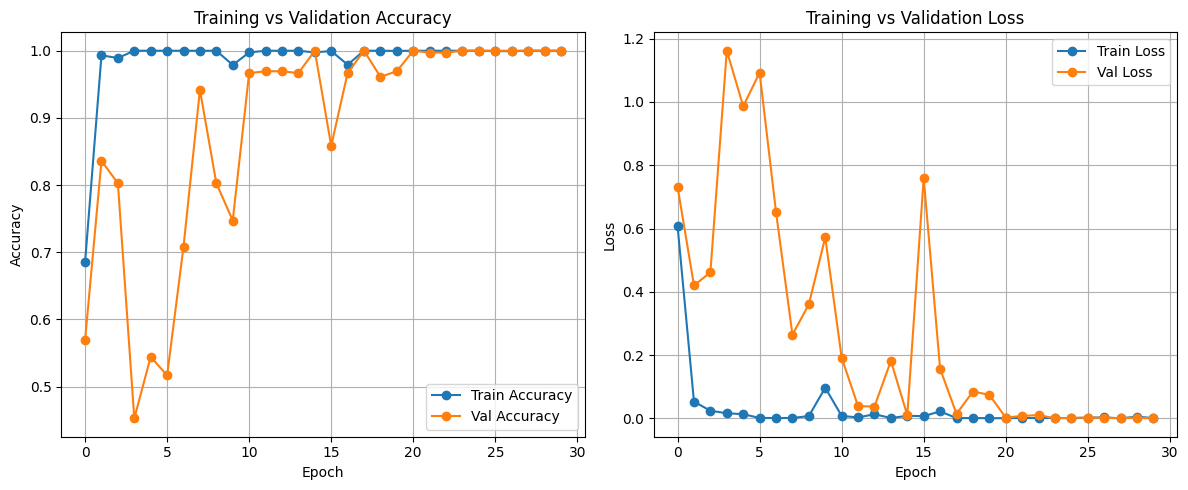

In [21]:
# === 1️⃣ Accuracy ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# === 2️⃣ Loss ===
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

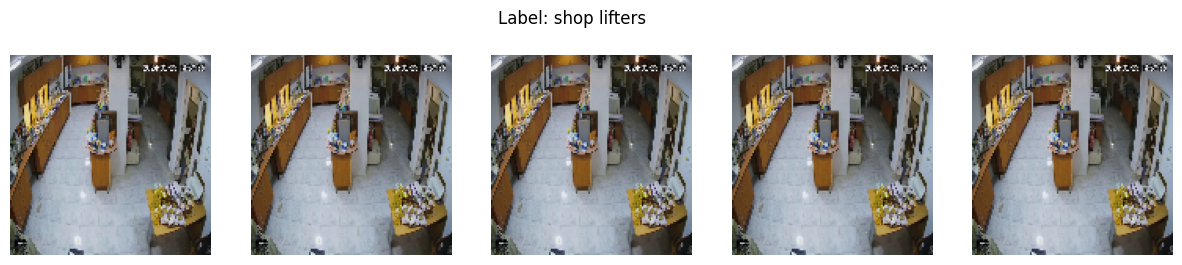

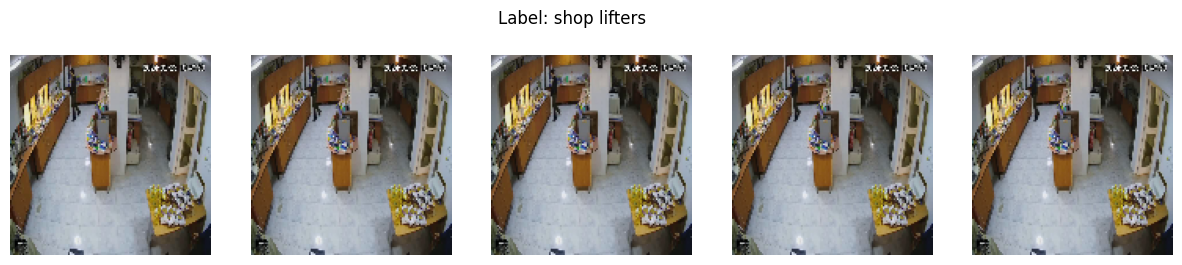

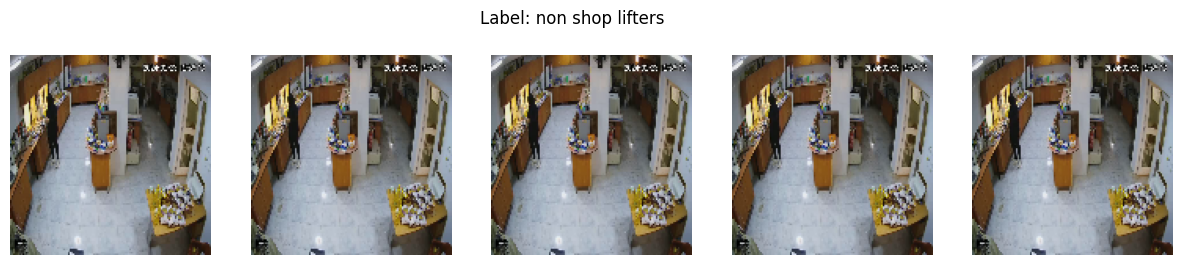

In [22]:
# Sample Frames
# ===========================
def show_sample_frames(file_list, num_samples=3):
    for i in range(num_samples):
        path, label = random.choice(file_list)
        frames = load_video(path)
        plt.figure(figsize=(15, 3))
        for j, frame in enumerate(frames[:min(5, NUM_FRAMES)]):
            plt.subplot(1, 5, j+1)
            plt.imshow(frame)
            plt.axis('off')
        plt.suptitle(f"Label: {CLASSES[label]}")
        plt.show()

show_sample_frames(train_files)

In [23]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.9699 - loss: 0.0313
Test Accuracy: 0.9731
Test Loss: 0.0314


In [28]:
from tensorflow.keras.models import Model

# Create a feature extractor from the trained model
feature_extractor = Model(
    inputs=model.input,
    outputs=model.get_layer(index=-3).output  # Dense(256, relu) layer
)


In [29]:
from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity

def get_embedding(video_path):
    frames = load_video(video_path, max_frames=NUM_FRAMES, resize=(IMG_SIZE, IMG_SIZE))
    input_tensor = np.expand_dims(frames, axis=0)
    embedding = feature_extractor.predict(input_tensor)[0]
    return embedding

def cosine_sim(vec1, vec2):
    return cosine_similarity([vec1], [vec2])[0][0]

def euclidean_dist(vec1, vec2):
    return norm(vec1 - vec2)


In [30]:
video_a = "/kaggle/input/shopdata/Shop DataSet/non shop lifters/shop_lifter_n_0_1.mp4"
video_b = "/kaggle/input/shopdata/Shop DataSet/shop lifters/shop_lifter_10.mp4"

emb_a = get_embedding(video_a)
emb_b = get_embedding(video_b)

cos_sim = cosine_sim(emb_a, emb_b)
euc_dist = euclidean_dist(emb_a, emb_b)

print(f"Cosine Similarity: {cos_sim:.4f}")
print(f"Euclidean Distance: {euc_dist:.4f}")


I0000 00:00:1757250974.999276    3301 service.cc:148] XLA service 0x9cffcd10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757250975.000208    3301 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757250975.000232    3301 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step


I0000 00:00:1757250984.358840    3301 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Cosine Similarity: 0.2880
Euclidean Distance: 17.1191


In [24]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_true, y_pred = [], []
for x_batch, y_batch in test_dataset:
    preds = model.predict(x_batch)
    y_true.extend(y_batch.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())

print(classification_report(y_true, y_pred, target_names=["Not Stolen", "Stolen"]))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 31s 31s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
              precision    recall  f1-score   support

  Not Stolen       1.00      0.98      0.99        81
      Stolen       0.95      1.00      0.97        39

    accuracy                           0.98       120
   macro avg       0.98      0.99      0.98       120
weighted avg       0.98      0.98      0.98       120

Confusion Matrix:
[[79  2]
 [ 0 39]]


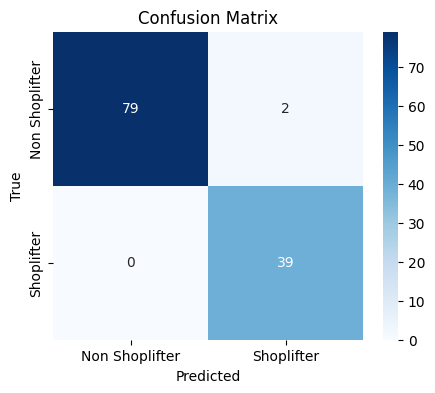

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
labels = ["Non Shoplifter", "Shoplifter"]

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

 ////////////////////////////////---------------------------------------------------------///////////

In [26]:
def predict_video(model, video_path):
    # Use the same load_video function
    frames = load_video(video_path, max_frames=NUM_FRAMES, resize=(IMG_SIZE, IMG_SIZE))
    
    # Expand dims to make it shape (1, NUM_FRAMES, IMG_SIZE, IMG_SIZE, 3)
    input_tensor = np.expand_dims(frames, axis=0)
    
    # Predict
    pred = model.predict(input_tensor)[0][0]
    
    # Convert to label
    label_idx = 1 if pred > 0.5 else 0
    label_name = CLASSES[label_idx]
    print(f"Predicted Score: {pred:.4f}")
    print(f"Predicted Label: {label_name}")
    return label_name

# Example usage:
video_path = "/kaggle/input/shopdata/Shop DataSet/shop lifters/shop_lifter_123.mp4" 
predict_video(model, video_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 31s 31s/step
Predicted Score: 1.0000
Predicted Label: shop lifters


'shop lifters'